In [4]:
# setting up stock basket
# pulling data from an API (stock API, then Ally Invest)
# analysing
# buy and sell decisions
# setting open and close times

## Trading Stocks with Trailing Stops Using Python

Ever want to make money trading stocks? Yeah, me too.

The problem is day trading is a zero-sum game. Ever dollar of gain made is a dollar paid by someone else. Then factor in costs. Trade inefficiencies. The fight against human fear and greed impulses. Day trading becomes a lesson in humility more often than an opportunity to quit the day job.

That has been my experience so far. I have a trading strategy. Then I get in my own way of executing it consistently. That is not a winning formula. Maybe making real day trades with code is.

### Enter Python

Here we are going to build a Python 3 program to day trade a real portfolio. This is what the program needs to do:
* Pull in realtime market data from an API.
* Update data on a portfolio of stocks.
* Connect to my real brokerage account.
* Use a decision engine to buy into positions.
* Sell positions to close.

### Goal: 0.5% Daily Net Gain

Making half a percent is harder than it seems. Trading costs, capital gains tax, flat movement, and trading losses all need taking into account.

The trick is getting the program to work towards this goal instead of monitoring it yourself. The key assumption here is on-the-fly human decisions are the very thing that gets in the way of making consistent income day trading.

Hypothesis: An automated day trading program using a trailing stop-loss strategy can return a half-percent net daily gain.

Assumptions:
* Trade size in bounds with trading cost approximately \$5 a trade to minimize effect on return.
* Positions should be opened on New York Stock Exchange after day open and all positions closed out before the bell.
* Operate on a manually selected menu of company shares.
* 

### Next Step

In the first section we are going to see how to set up a Jupyter Notebook in our program and figure out what we need to get started.

[ link to next section ]

## Part 1: Updating Stock Data with Alpha Vantage API

First we will make a portfolio of stocks to trade in. We are not in this to make an omni-bot; a program to analyze the entire market and make optimum trades. The goal of this program is much less ambitious: a half-percent net gain each trading day.

Testing our hypothesis (failing to disprove we can make 0.5% a day with this scheme) by putting just a few manually selected stocks in our basket will make starting much easier.

We'll build our portfolio by hand in a Python dictionary. Later this will work well with JSON feeds from the APIs.

The schema for the dictionary is:

stock symbol \\  
    -price  
    -day start price  
    -current price  
    -timestamp current price
    

In [102]:
# `basket` is what we will call all the stocks we will potentially trade
basket = {
    # AT&T
    'T': {
        'price': 36.91,
        'day_start_price': 37.19,
        'timestamp_current': None,
    },
    # Tesla Motors
    'TSLA': {
        'price': 306.16,
        'day_start_price': 302.25,
        'timestamp_current': None,
    },
    # Kroger
    'KR': {
        'price': 26.51,
        'day_start_price': 26.74,
        'timestamp_current': None,
    },
}

The values you initialize with do not really matter; when we make a call to a stock monitoring API, we will overwrite.

### Pulling Market Data with Alpha Vantage API

When we later hook this program into a real brokerage account, we can (and should) get the market data through there. For now, however, we can skip this step and use Alpha Vantage's easy-to-use API to simulate trading. This does not replace testing the program on a real portfolio with real dollars. What it does do is let us scope out major flaws in our scheme before real money is on the line.

#### Getting Your API Key

Go to [Alpha Vantage's website](https://www.alphavantage.co/ "Alpha Vantage") to get your free API key. Follow the instructions and keep your key in a saved place and keep it private.

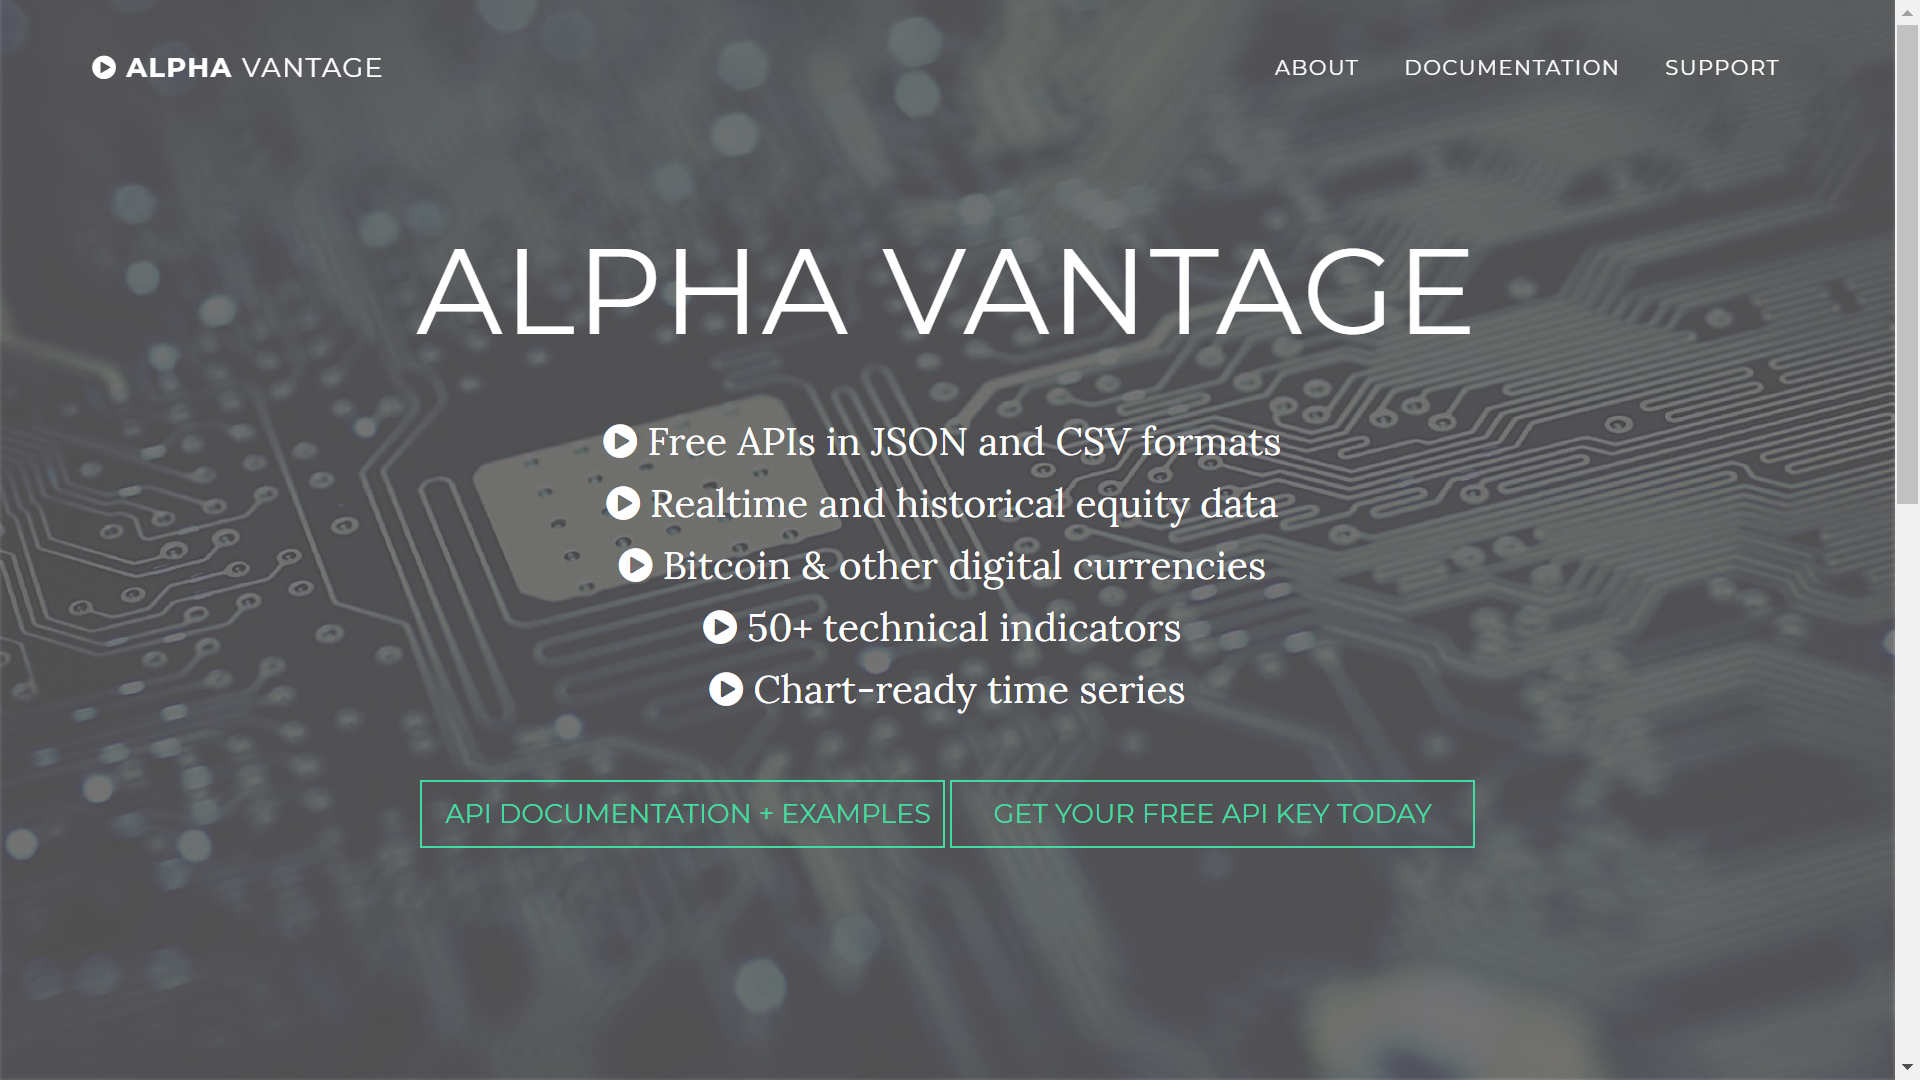

Let's start by making a function for grabbing the populating our basket. We will use Alpha Vantage's [intraday data](https://www.alphavantage.co/documentation/#intraday "Alpha Vantage Intraday") function. We will use Python's excellent `requests` library, remember to import it.

Try this example of using Alpha Vantage's Time Series Data API call. No API key needed. [Click here.](https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=1min&apikey=demo "Example API Call")

This is what returns.

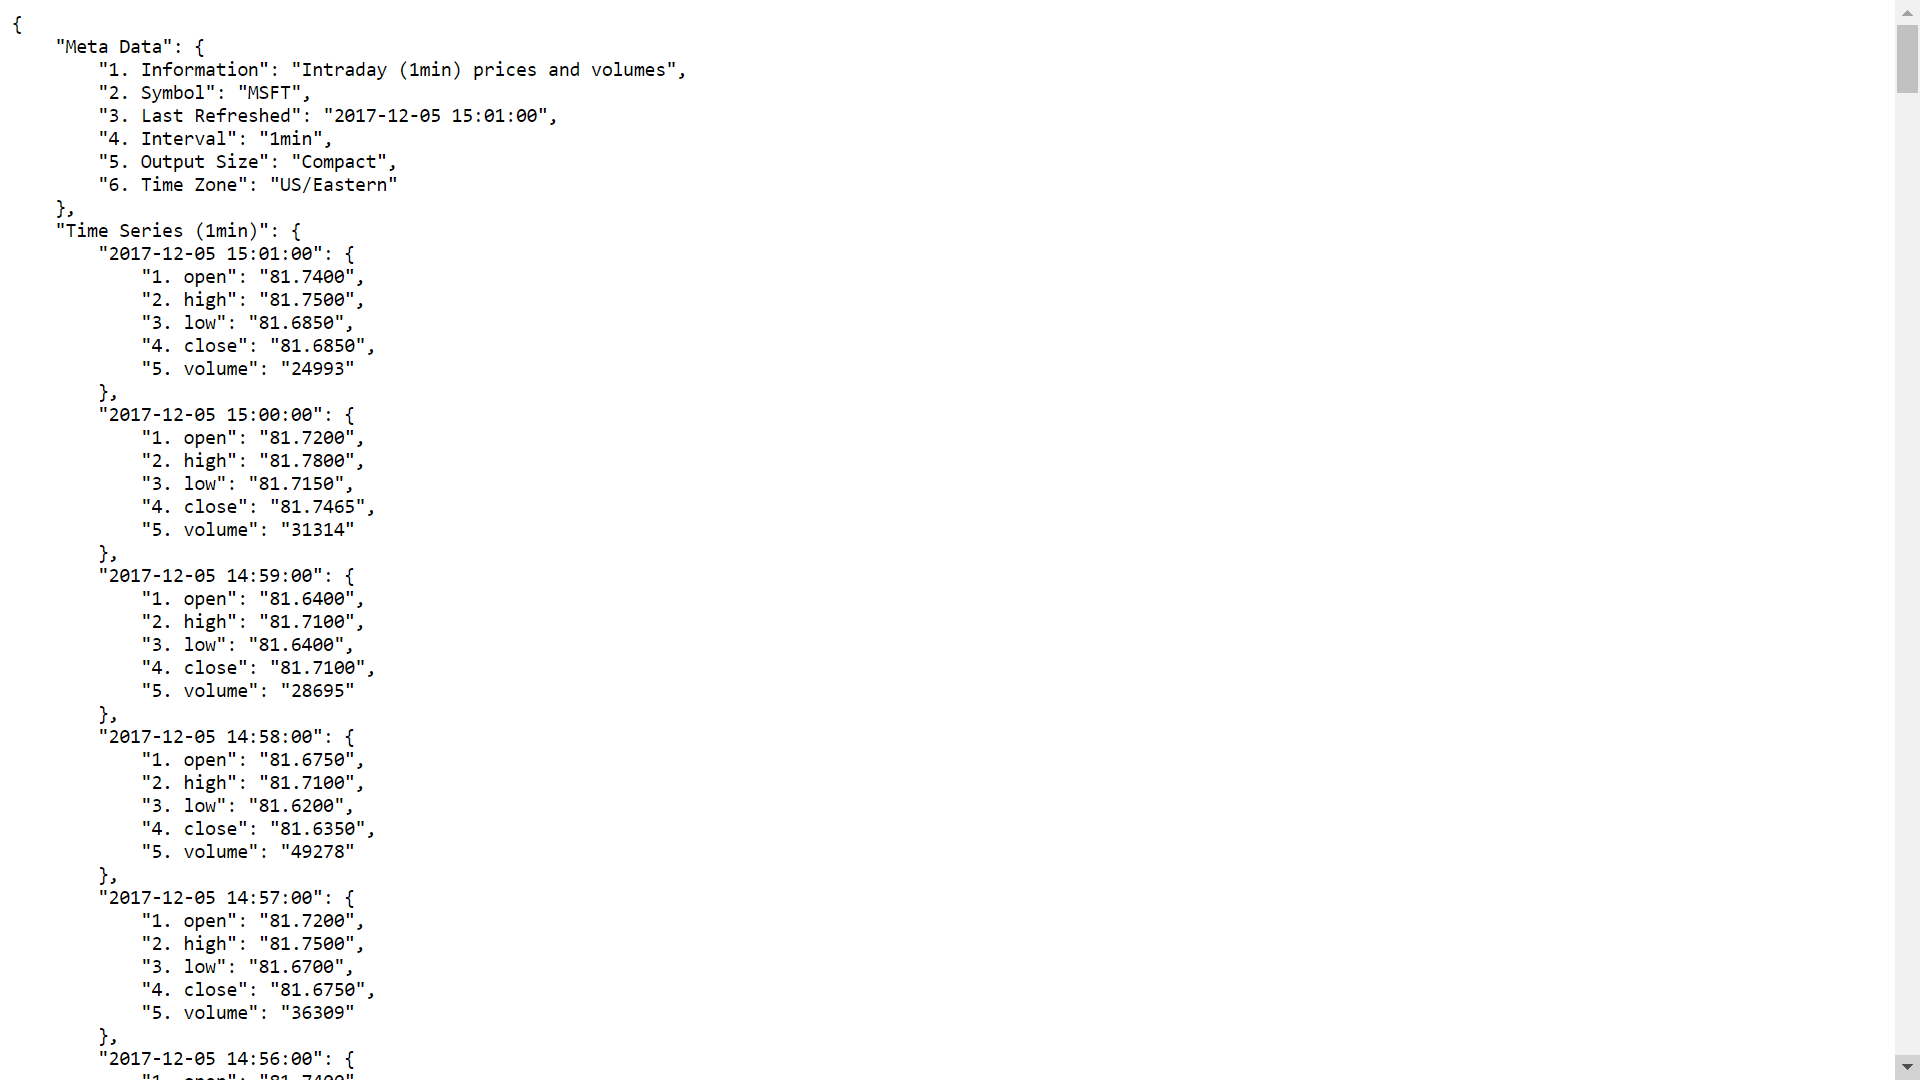

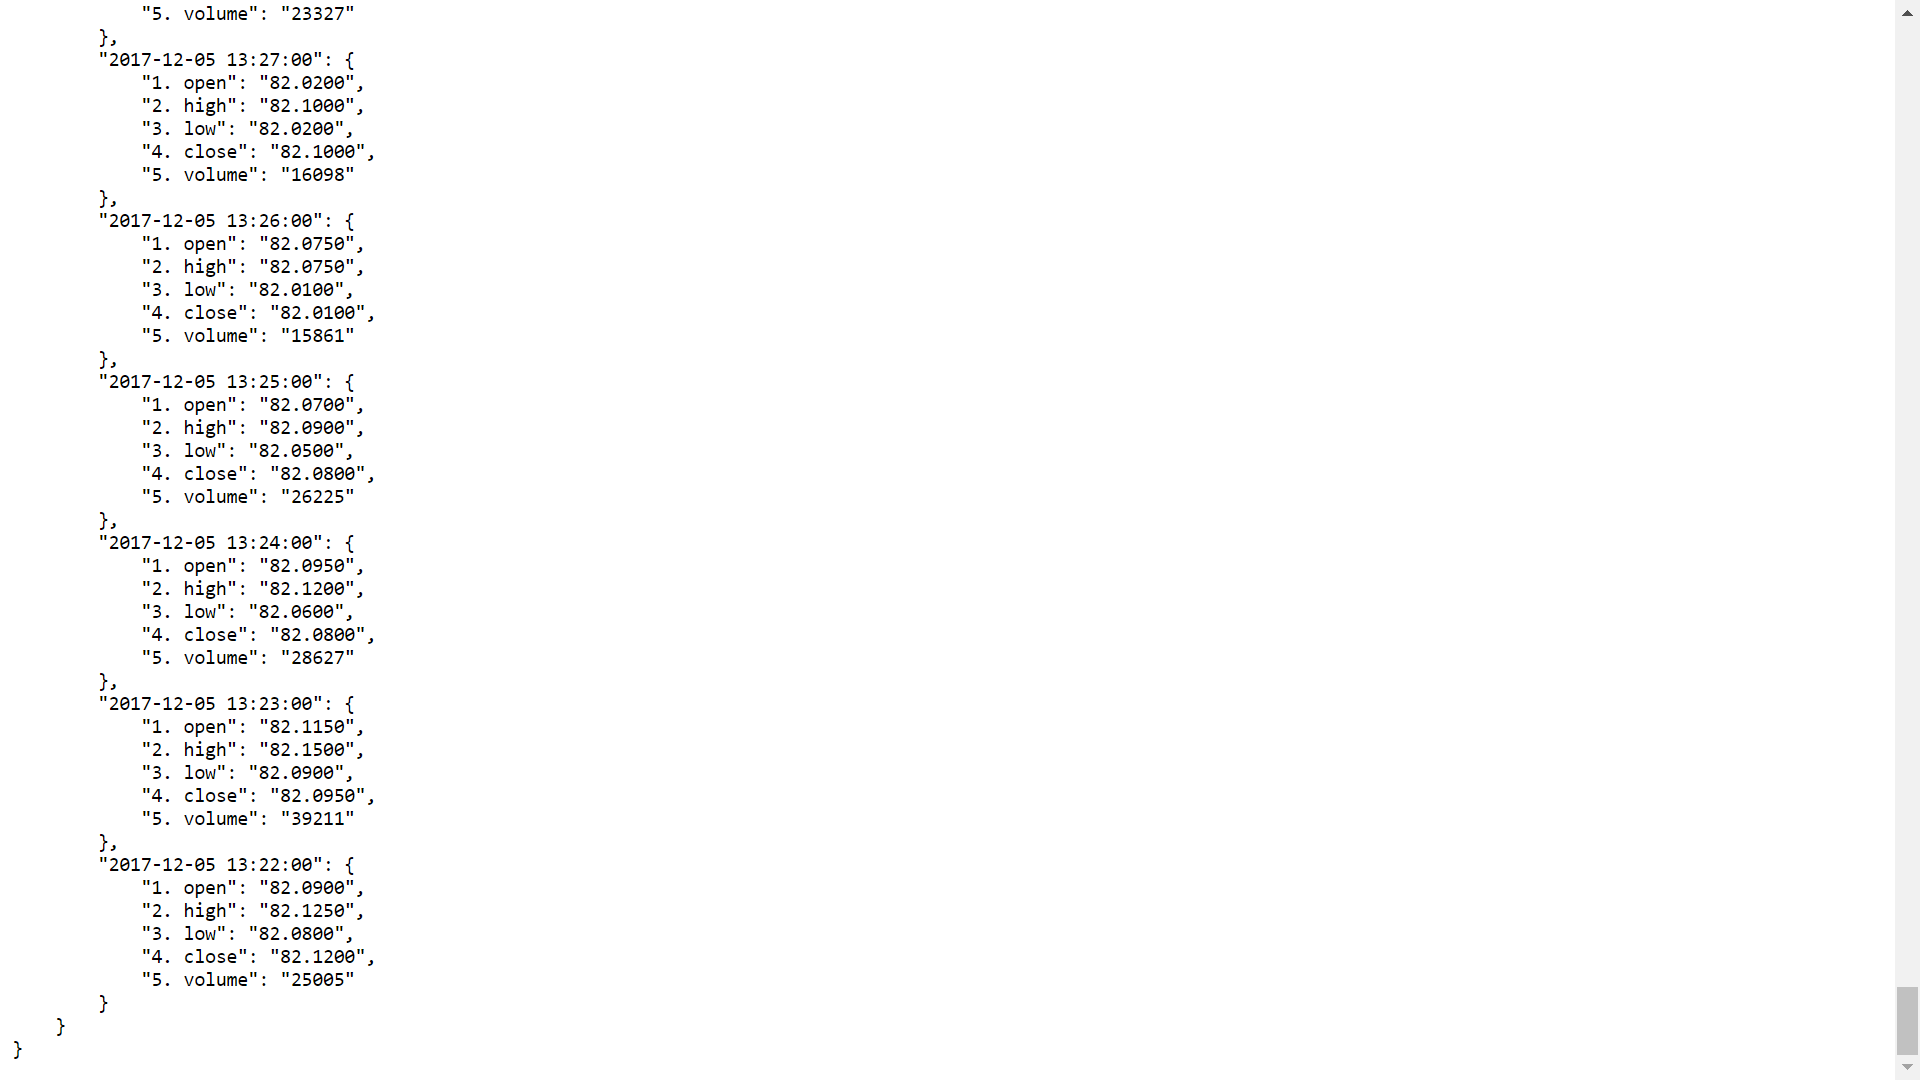

We are interested in the first (newest) and last (oldest) values of the "Time Series (1min)" key. We are going to update our `basket` dictionary `price` and `day_start_price` with these values, respectively, and use the timestamp to update our own timestamp. Alpha Vantage returns Eastern Standard Time (UTC -5), which is the time of the New York Stock Exchange. The NYSE is open from 0830 hours to 1600 hours.

In [114]:
baseurl = 'https://www.alphavantage.co/query?' # this won't change
parameters = set([ # if parameter is blank, for now comment out
    'function=TIME_SERIES_INTRADAY', # we will use only TIME_SERIES_INTRADAY
    'apikey=730USPV7R2XYTHIG', # TODO: load API key from secure file
    'outputsize=compact', # compact for last 100, full for complete time series
    'symbol=',
    'interval=15min', # can be 1min, 5min, 15min, 30min, 60min
])

def build_GET_request(stock_symbol):
    request_string = '&'.join(parameters)
    request_string = request_string.replace('symbol=', 'symbol='+stock_symbol)
    url = baseurl + request_string
    return url

In [126]:
import requests

def basket_update():
    basket_update = dict()
    for stock_symbol in basket.keys():
        r = requests.get(build_GET_request(stock_symbol))
        basket_update[stock_symbol] = r.json()
    return basket_update
    
data = basket_update()

In [130]:
list_ = list()
for key in data.keys():
    list_.append(key)
list_

['T', 'TSLA', 'KR']